In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import gymnasium as gym
import numpy as np
import time
import random
from gymnasium.wrappers import RecordVideo

%matplotlib inline

device = "cpu"

## **MLP arquitecture**

In [2]:
class Torch_MLP(nn.Module):
    def __init__(self, layer_dims: list):
        super(Torch_MLP, self).__init__()
        layers = []
        for i in range(len(layer_dims) - 1):
            layers.append(nn.Linear(layer_dims[i], layer_dims[i + 1]))
            if i < len(layer_dims) - 2:  # No ReLU on the output layer
                layers.append(nn.ReLU())
        self.network = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x)

    def print_num_parameters(self):
        total_params = sum(p.numel() for p in self.parameters())
        print(f"Total number of parameters: {total_params}")

## **Training**

In [ ]:
env = gym.make('LunarLander-v3')
state_space = env.observation_space.shape[0]
action_space = (env.action_space.n)

layer_dims = [state_space, 32, 32, action_space]
model = Torch_MLP(layer_dims)
model.print_num_parameters()
model.to(device)

learning_rate = 0.001
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

EPISODES = 1000
trace = 50
gamma = 0.99

episode_reward_history = []

start = time.time()
for episode in range(EPISODES):
    state, _ = env.reset()
    state = torch.FloatTensor(state).to(device)
    done = False
    episode_reward = 0

    if episode + 1 % trace == 0:
        episode_start = time.time()

    while not done or truncated:
        # Forward
        q_values = model(state)
        epsilon = max(0.1, 1 - episode / (EPISODES * 0.5))  # Decay lineal
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            action = torch.argmax(q_values).item()

        next_state, reward, done, truncated, _ = env.step(action)
        next_state = torch.FloatTensor(next_state).to(device)
        episode_reward += reward

        # Compute target
        with torch.no_grad():
            target = reward + gamma * torch.max(model(next_state)) * (1 - done)
        target = torch.FloatTensor([target]).to(device)

        # Compute loss
        q_value = q_values[action]
        loss = loss_function(q_value, target)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        state = next_state

    episode_reward_history.append(episode_reward)
    
    if episode + 1 % trace == 0:
        minutos, segundos = divmod(time.time()-episode_start, 60)
        print(f"Episode {episode + 1}, Total Reward: {episode_reward}, Time: {int(minutos)} minutes y {segundos:.2f} seconds")

torch.save(model, f"results_p1/lunar_lander_MLP_{EPISODES}.pt")
minutos, segundos = divmod(time.time()-start, 60)
print(f"*******Tiempo entreno: {int(minutos)} minutos y {segundos:.2f} segundos*******")

Total number of parameters: 1476


KeyboardInterrupt: 

## **Reward history**

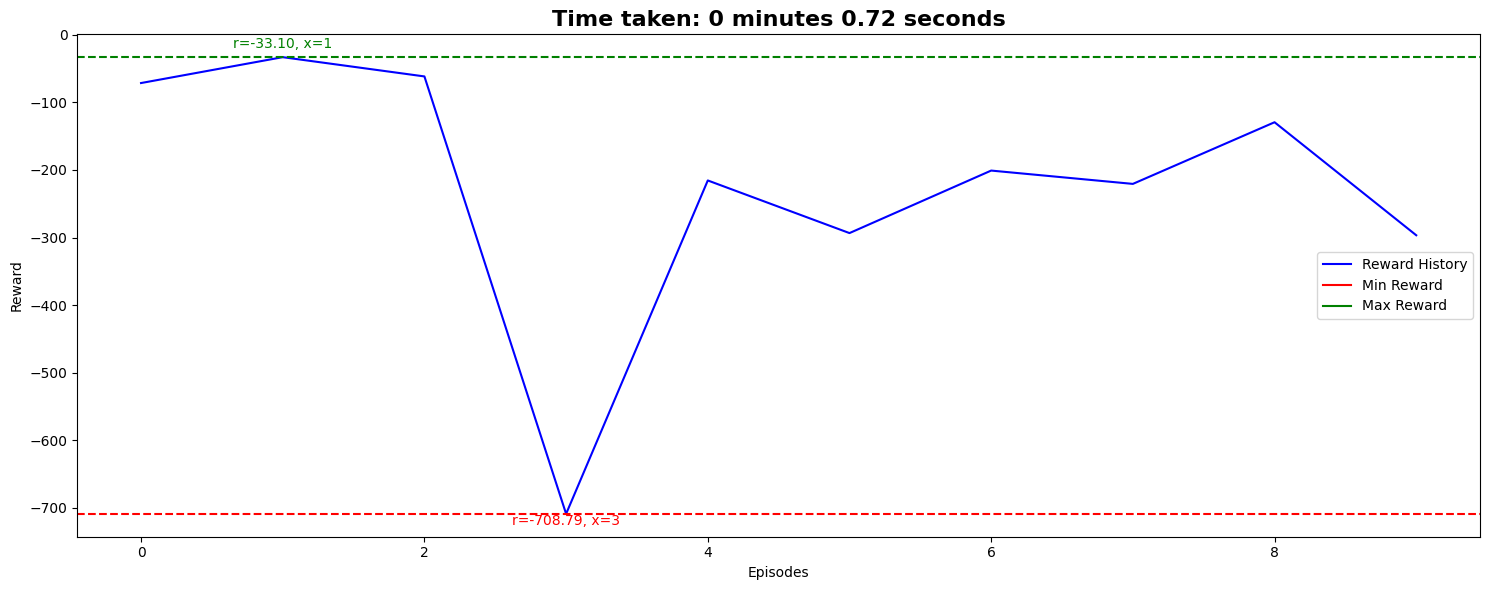

In [ ]:
def plot_evolution():
    plt.figure(figsize=(15, 6))
    plt.plot(range(EPISODES), episode_reward_history, label="Reward History", color="blue")

    # Adding min and max bars
    min_reward = min(episode_reward_history)
    max_reward = max(episode_reward_history)
    min_episode = episode_reward_history.index(min_reward)
    max_episode = episode_reward_history.index(max_reward)

    ax = plt.gca()
    ymin_axis, ymax_axis = ax.get_ylim()
    offset = (ymax_axis - ymin_axis) * 0.02

    # Adjust offsets; change sign as needed (positive: above, negative: below)
    min_offset = -offset-1.9  # places min text below the line
    max_offset = offset-2.0   # places max text above the line

    plt.plot(min_reward, label="Min Reward", color='r')
    plt.axhline(y=min_reward, color='red', linestyle='--')
    plt.text(min_episode, min_reward + min_offset, f"r={min_reward:.2f}, x={min_episode}", color='r', ha="center")

    plt.plot(max_reward, label="Max Reward", color='g')
    plt.axhline(y=max_reward, color='green', linestyle='--')
    plt.text(max_episode, max_reward + max_offset, f"r={max_reward:.2f}, x={max_episode}", color='g', ha="center")

    plt.xlabel("Episodes")
    plt.ylabel("Reward")
    plt.title(f"Time taken: {int(minutos)} minutes {segundos:.2f} seconds", fontsize=16, ha='center', fontweight='bold')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"results_p1/lunar_lander_MLP_{EPISODES}.png")
    plt.show()

plot_evolution()

## **Test model**

In [ ]:
test_model = torch.load(f"results_p1/lunar_lander_MLP_{EPISODES}.pt")

num_episodes_test = 5
destiny_folder = "results_p1/videos"
test_env = gym.make("LunarLander-v3", render_mode="rgb_array")
test_env = RecordVideo(test_env, video_folder=destiny_folder, name_prefix=f"LL-MLP-{EPISODES}", episode_trigger=lambda x: x < num_episodes_test)  

def policy(state):
    state_tensor = torch.tensor(state, dtype=torch.float)
    with torch.no_grad():  # Disable gradient calculation
        action_values = test_model(state_tensor)
    return torch.argmax(action_values).item()
    
for episode in range(num_episodes_test):
    state, _ = test_env.reset()
    done = False
    total_reward = 0
    while not done:
        action = policy(state)  
        next_state, reward, done, _, _ = test_env.step(action) 
        total_reward += reward
        state = next_state
        if done:
            print(f"Episode {episode}: Total Reward = {total_reward}")

test_env.close()

C:\Users\aleja\AppData\Local\Temp\ipykernel_16128\3794645361.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model = torch.load(f"results_p1/lunar_lander_MLP_{EPISO

Episode 0: Total Reward = -136.84217160495166
Episode 1: Total Reward = -23.888077374330436
Episode 2: Total Reward = -146.66977472496762
Episode 3: Total Reward = -325.5881119427878
Episode 4: Total Reward = 3.3176419916127315
